In [10]:
# ! pip install ../Portal/. #manually pip installed Portal

Processing /home/olam/Portal
  Preparing metadata (setup.py) ... done
  Created wheel for p: filename=p-1.0-py3-none-any.whl size=16153 sha256=bdc21cb03c32458c98861b6316811996d80f0fe57e0f7a3973ac88a9596b13b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1s2ozlt/wheels/f8/ed/39/f7434bb3c16d3e2034e478dcbca2ca0f98e025ce68aa95c11e
Successfully built p
  Attempting uninstall: p
    Found existing installation: p 1.0
    Uninstalling p-1.0:
      Successfully uninstalled p-1.0


In [1]:
import portal

/home/olam/miniconda3/envs/integration/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import scanpy as sc

In [3]:
import rpy2.robjects
import rpy2.robjects as ro
import anndata2ri

## Preprocess

In [90]:
savas = sc.read_h5ad('./processed/savas_filtered.h5ad')

In [91]:
wu = sc.read_h5ad('./processed/wu_filtered.h5ad')

In [92]:
xu = sc.read_h5ad('./processed/xu_filtered.h5ad')

In [22]:
sc.pp.highly_variable_genes(xu, n_top_genes=10000, flavor='cell_ranger')
sc.pp.highly_variable_genes(wu, n_top_genes=10000, flavor='cell_ranger')
sc.pp.highly_variable_genes(savas, n_top_genes=10000, flavor='cell_ranger')

In [23]:
sc.pp.scale(xu, max_value=10)
sc.pp.scale(wu, max_value=10)
sc.pp.scale(savas, max_value=10)

In [93]:
adata_all = wu.concatenate([xu, savas] , batch_categories=['wu', 'xu', 'savas'] )

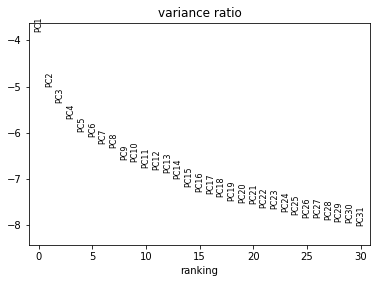

In [25]:
sc.tl.pca(adata_total)
sc.pl.pca_variance_ratio(adata_total, log=True)

In [31]:
import numpy as np
import os

npcs=30
sample_size_list = []
for adata in [wu, xu,savas]:
    sample_size_list.append(adata.shape[0])


indices = np.cumsum(sample_size_list)



data_path = "./preprocess/"

if not os.path.exists(data_path):
    os.makedirs(data_path)

# if save_embedding:
#     for i in range(len(indices)):
#         if i == 0:
#             np.save(os.path.join(data_path, "lowdim_1.npy"), 
#                     adata_total.obsm["X_pca"][:indices[0], :npcs])
#         else:
#             np.save(os.path.join(data_path, "lowdim_%d.npy" % (i + 1)), 
#                     adata_total.obsm["X_pca"][indices[i-1]:indices[i], :npcs])

lowdim = adata_total.obsm["X_pca"].copy()
lowdim_list = [lowdim[:indices[0], :npcs] if i == 0 else lowdim[indices[i - 1]:indices[i], :npcs] for i in range(len(indices))]


## Integrate

In [32]:
model = portal.model.Model()

In [33]:
integrated_data = portal.utils.integrate_datasets(lowdim_list, search_cos=True)

Incrementally integrating 3 datasets...
Integrating the 2-th dataset to the 1-st dataset...
Begining time:  Mon Jun 27 23:56:55 2022
step 0, loss_D=14.894514, loss_GAN=3.522398, loss_AE=471.018738, loss_cos=30.209284, loss_LA=348.870544
step 200, loss_D=1.406510, loss_GAN=6.993022, loss_AE=18.220961, loss_cos=13.000435, loss_LA=5.825057
step 400, loss_D=1.069251, loss_GAN=6.032588, loss_AE=12.011240, loss_cos=8.710149, loss_LA=3.171177
step 600, loss_D=1.213095, loss_GAN=6.016559, loss_AE=9.796213, loss_cos=7.827578, loss_LA=2.055182
step 800, loss_D=0.895758, loss_GAN=6.319281, loss_AE=9.089065, loss_cos=6.625774, loss_LA=1.682707
step 1000, loss_D=0.978860, loss_GAN=6.179900, loss_AE=8.155985, loss_cos=6.239503, loss_LA=1.488298
step 1200, loss_D=1.019188, loss_GAN=6.629283, loss_AE=8.295403, loss_cos=5.980905, loss_LA=1.348290
step 1400, loss_D=0.861066, loss_GAN=6.563837, loss_AE=7.143098, loss_cos=5.535777, loss_LA=1.017998
step 1600, loss_D=0.769014, loss_GAN=7.066922, loss_AE=7.

In [35]:
integrated_data.shape

(149895, 30)

## Clustering analysis

In [51]:
adata_total.obsm['X_pca'] = integrated_data

In [41]:
import numpy

In [42]:
numpy.save('portal.npy', integrated_data)

In [54]:
sc.pp.neighbors(adata_total, n_neighbors=30, n_pcs=20, use_rep='X_pca')

In [56]:
sc.tl.louvain(adata_total, resolution=0.3)

In [57]:
sc.tl.paga(adata_total)
sc.pl.paga(adata_total, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_total, init_pos='paga')

... storing 'barcode' as categorical
... storing 'cell_type_original' as categorical
... storing 'cell_type_original_subset' as categorical
... storing 'BC subtype' as categorical
... storing 'Patient' as categorical
... storing 'bars' as categorical
... storing 'Sample' as categorical
... storing 'Tissue' as categorical


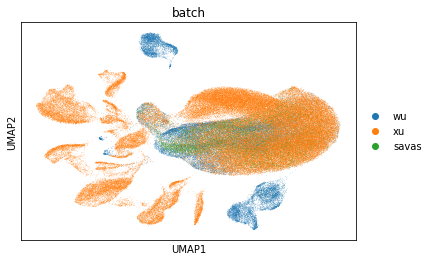

In [59]:
sc.pl.umap(adata_total, color='batch')

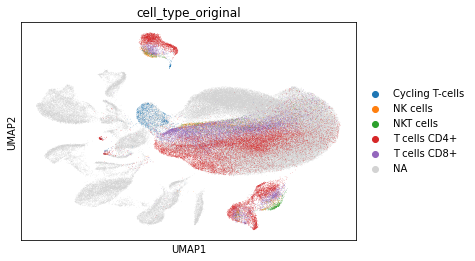

In [60]:
sc.pl.umap(adata_total, color=['cell_type_original'])

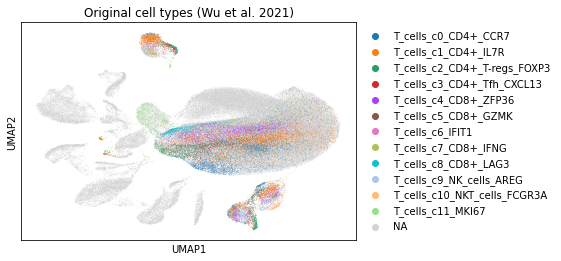

In [62]:
sc.pl.umap(adata_total, color=['cell_type_original_subset'], title="Original cell types (Wu et al. 2021)")

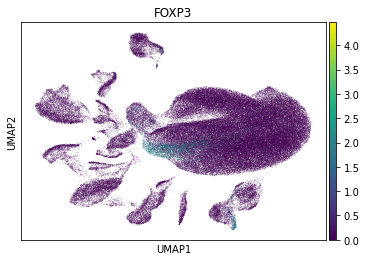

In [97]:
sc.pl.umap(adata_all, color=['FOXP3'])

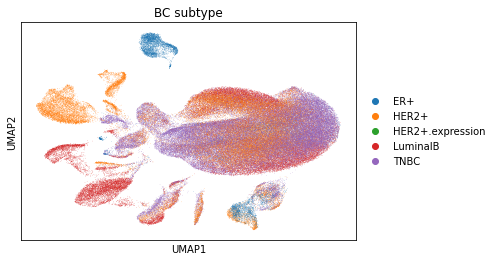

In [81]:
sc.pl.umap(adata_total, color=['BC subtype'])

In [80]:
adata_total.obs.loc[adata_total.obs['BC subtype'] == 'HER2+.expression', 'BC subtype'] = 'HER2+'

In [74]:
adata_total.obs.loc[adata_total.obs['batch']=='savas', 'BC subtype'] = 'TNBC'

In [76]:
adata_total.obs['BC subtype'].unique()

['HER2+', 'TNBC', 'ER+', 'LuminalB']
Categories (4, object): ['HER2+', 'TNBC', 'ER+', 'LuminalB']

In [78]:
adata_total.obs['Subtype'] = adata_total.obs['BC subtype']

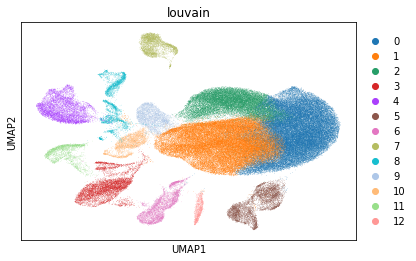

In [82]:
sc.pl.umap(adata_total, color=['louvain'])

In [ ]:
sc.pl.umap(adata_total, color=['FOXP3'])

In [94]:
adata_all.obsm['X_umap'] = adata_total.obsm['X_umap']
adata_all.obsm['X_pca'] = adata_total.obsm['X_pca']

In [86]:
results_file = './processed/portal_all.h5ad'
adata_all.write(results_file)

... storing 'barcode' as categorical
... storing 'cell_type_original' as categorical
... storing 'cell_type_original_subset' as categorical
... storing 'BC subtype' as categorical
... storing 'Patient' as categorical
... storing 'bars' as categorical
... storing 'Sample' as categorical
... storing 'Tissue' as categorical


... storing 'barcode' as categorical
... storing 'cell_type_original' as categorical
... storing 'cell_type_original_subset' as categorical
... storing 'BC subtype' as categorical
... storing 'Patient' as categorical
... storing 'bars' as categorical
... storing 'Sample' as categorical
... storing 'Tissue' as categorical


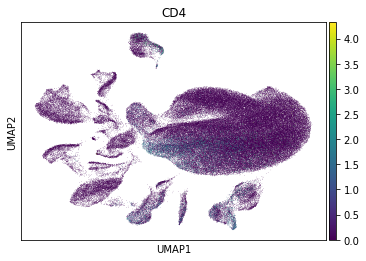

In [95]:
sc.pl.umap(adata_all, color=['CD4'])

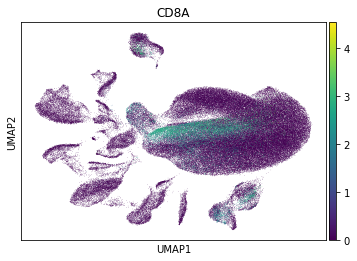

In [96]:
sc.pl.umap(adata_all, color=['CD8A'])

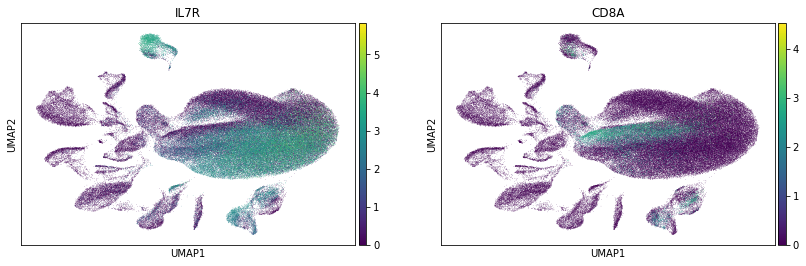

In [101]:
sc.pl.umap(adata_all, color=['IL7R','CD8A'])

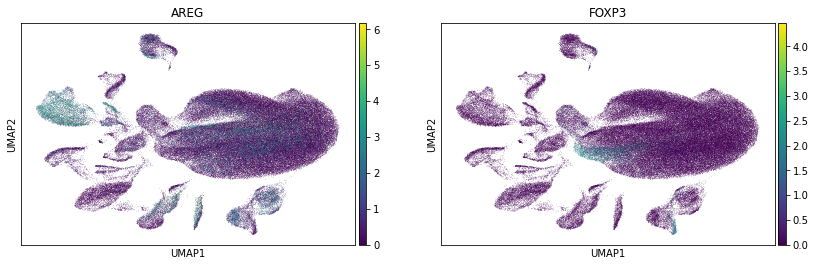

In [102]:
sc.pl.umap(adata_all, color=['AREG','FOXP3'])

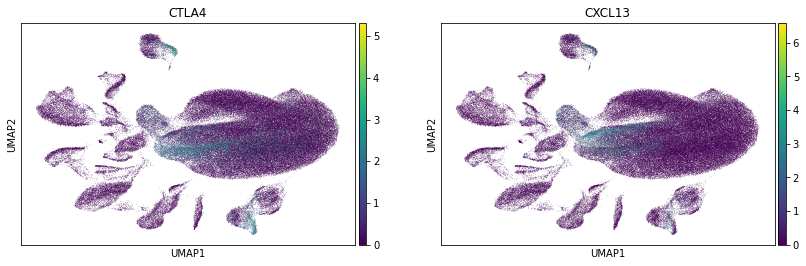

In [103]:
sc.pl.umap(adata_all, color=['CTLA4','CXCL13'])

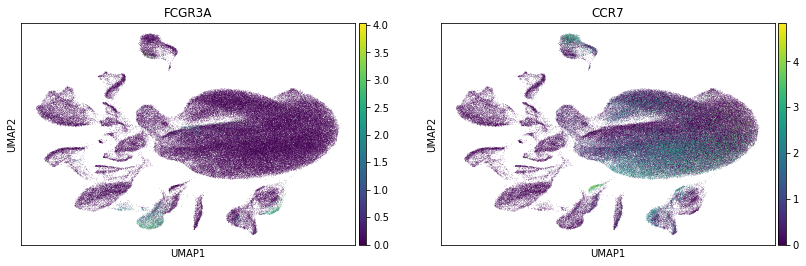

In [104]:
sc.pl.umap(adata_all, color=['FCGR3A','CCR7'])